[505, 451, 4982]
[150, 443, 4806]


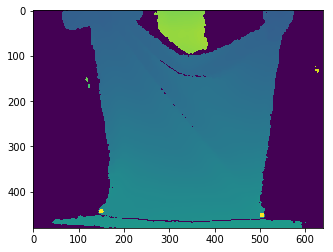

(480, 640)


In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
depth = cv2.imread("data/2018-01-19-00-29-15/depth/0501.png",cv2.IMREAD_UNCHANGED)
def get_depth(depth,p):
    return depth[p[1]][p[0]]
def add_depth(depth,p):
    return p + [get_depth(depth,p)]
hand1=[505,451]
hand2=[150,443]
hand1 = add_depth(depth, hand1)
hand2 = add_depth(depth, hand2)
print(hand1)
print(hand2)
cv2.circle(depth,tuple(hand1[:2]), 5, (10000,0,0), -1)
cv2.circle(depth,tuple(hand2[:2]), 5, (10000,0,0), -1)
plt.imshow(depth)
plt.show()
print(depth.shape)

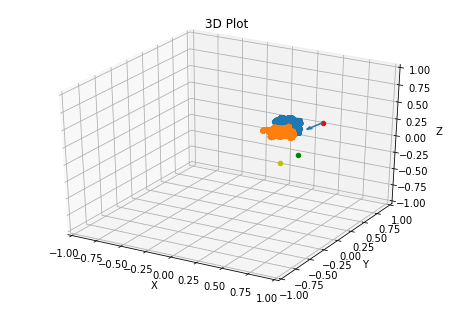

In [43]:
#transfer the hands position to the real world_coordination
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
#https://math.stackexchange.com/questions/82602/how-to-find-camera-position-and-rotation-from-a-4x4-matrix


class Plot3d:
    def __init__(self):
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        # Setting the axes properties
        l = 1
        if True:
            ax.set_xlim3d([-l, l])
            ax.set_ylim3d([-l, l])
            ax.set_zlim3d([-l, l])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Plot')
        self.ax = ax
        pass

    def draw_points(self,points):
        self.ax.scatter(points[:,0],points[:,1],points[:,2])
        pass
    def draw_point(self,p,c):
        self.ax.scatter(p[0],p[1],p[2],c=c)
        pass
    def draw_vector(self,s,e):
        d = e-s
        self.ax.quiver(s[0],s[1],s[2],d[0],d[1],d[2])
        pass
    
    
class CameraTransform:
    def __init__(self,R,t):
        # model view matrix 
        MV = np.hstack((R,t))
        self.model_view = np.vstack((MV,(0,0,0,1)))
        self.camera_position = -np.dot(R.T,t).reshape((-1))
        self.camera_orientation = np.dot(R.T,(0,0,1))
        pass
    def world_to_cam(self, point_in_world):
        p = np.hstack((point_in_world,1))
        p = np.dot(self.model_view, p)
        p = p[:3]/p[3]
        return p
    def cam_to_world(self, point_in_camera):
        p = np.hstack((point_in_camera,1))
        from numpy.linalg import inv
        p = np.dot(inv(self.model_view),p)
        p = p[:3]/p[3]
        return p
    def print(self):
        print("position:",self.camera_position)
        print("orientation:",self.camera_orientation)

R = [ -2.4512346789053452e-02, 9.9968955285579986e-01,
4.4657323994911069e-03, 6.8043109798842805e-01,
1.9956487329708672e-02, -7.3254027841731739e-01,
-7.3240198371191967e-01, -1.4917658141606671e-02,
-6.8070904043535008e-01 ]
t = [ 3.4787262116370329e-02, -1.1033486540439220e-01,
1.0847564970952182e+00 ]
R = np.array(R).reshape((3,3))
t = np.array(t).reshape((3,1))
cam = CameraTransform(R,t)

# points in the camera axis
hand_left=[-0.1491528695821762, 0.221684031188488, 0.637074425816536]
hand_right=[0.18609340742230415, 0.25525905936956406, 0.672452837228775]
hand_left = cam.cam_to_world(hand_left)
hand_right = cam.cam_to_world(hand_right)

robot_pos = np.load('robot_arms.npy')

p3d = Plot3d()
p3d.draw_point(cam.camera_position, c='r')
p3d.draw_vector(cam.camera_position, cam.camera_position+cam.camera_orientation*0.2)
p3d.draw_point(hand_left, c='y')
p3d.draw_point(hand_right, c='g')
p3d.draw_points(robot_pos[:,:3])
p3d.draw_points(robot_pos[:,-3:])
plt.show()

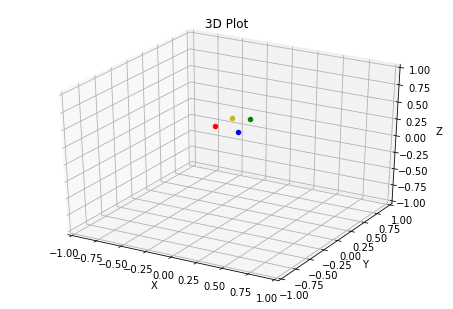

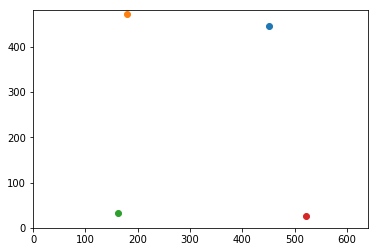

In [46]:
# intrinsic matrix
ppx = 311.560699463
ppy = 251.426208496
fx = 619.985595703
fy = 619.985656738
dev_depth_scale = 0.000124986647279
def deproject(p):
    depth = p[2]*dev_depth_scale
    x = (p[0] - ppx)/fx
    y = (p[1] - ppy)/fy
    x = x*depth
    y = y*depth
    z = depth
    return [x,y,z]

# point to pixel
def project(p):
    px = fx*p[0]/p[2]+ppx
    py = fy*p[1]/p[2]+ppy
    pz = p[2]/dev_depth_scale
    return [px,py,pz]

h=480
w=640

hand_left=[-0.08309672027826309, 0.13976304233074188, 0.39112165570259094]
pl = project(hand_left)
hand_right=[0.09550348855555058, 0.1327906884253025, 0.42547494173049927]
pr = project(hand_right)

fr = 501
robot_pos = np.load('robot_arms.npy')
rl = robot_pos[fr,:3]
rr = robot_pos[fr,-3:]
rl = cam.world_to_cam(rl)
rr = cam.world_to_cam(rr)
p3d = Plot3d()
p3d.draw_point(hand_left, c='y')
p3d.draw_point(hand_right, c='g')
p3d.draw_point(rl, c='b')
p3d.draw_point(rr, c='r')
plt.show()
rl = project(rl)
rr = project(rr)

axes = plt.gca()
axes.set_xlim([0,w])
axes.set_ylim([0,h])
plt.plot(pr[0],pr[1], marker='o')
plt.plot(pl[0],pl[1], marker='o')
plt.plot(rr[0],rr[1], marker='o')
plt.plot(rl[0],rl[1], marker='o')
plt.show()